In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# plotting defaults
%matplotlib inline
plt.style.use('default')
np.random.seed(42)

### Load Data

In [2]:
red = pd.read_csv('winequality-red.csv', sep=';')
white = pd.read_csv('winequality-white.csv', sep=';')

red['color'] = 'red'
white['color'] = 'white'
df = pd.concat([red, white], ignore_index=True)
df.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Note number of rows and columns, confirm the dataset meets the >1000 instances & >=10 features requirement.

In [3]:
df.shape

(6497, 13)

### Quick statistics

In [4]:
# numeric summary
df.describe().T
# counts for categorical
df['color'].value_counts(), df['quality'].value_counts().sort_index()


(color
 white    4898
 red      1599
 Name: count, dtype: int64,
 quality
 3      30
 4     216
 5    2138
 6    2836
 7    1079
 8     193
 9       5
 Name: count, dtype: int64)

### Missing values & deliberate data corruption

In [5]:
# Introduce synthetic missingness and outliers (document this in markdown)
df_corrupt = df.copy()

# 1) Randomly set 1% of values in 'pH' to NaN
n = int(0.01 * len(df_corrupt))
idx = np.random.choice(df_corrupt.index, n, replace=False)
df_corrupt.loc[idx, 'pH'] = np.nan

# 2) Insert some extreme outliers in 'alcohol' (e.g., multiply 0.2% by 5)
m = max(1, int(0.002 * len(df_corrupt)))
out_idx = np.random.choice(df_corrupt.index, m, replace=False)
df_corrupt.loc[out_idx, 'alcohol'] = df_corrupt.loc[out_idx, 'alcohol'] * 5

# confirm
df_corrupt.isna().sum()


fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar           0
chlorides                0
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                      64
sulphates                0
alcohol                  0
quality                  0
color                    0
dtype: int64

### Visualize

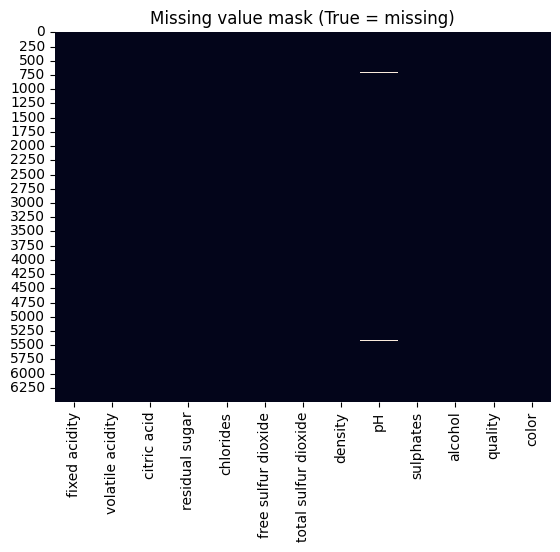

In [6]:
# simple missingness visualization
sns.heatmap(df_corrupt.isna(), cbar=False)
plt.title('Missing value mask (True = missing)');


### Histograms of features

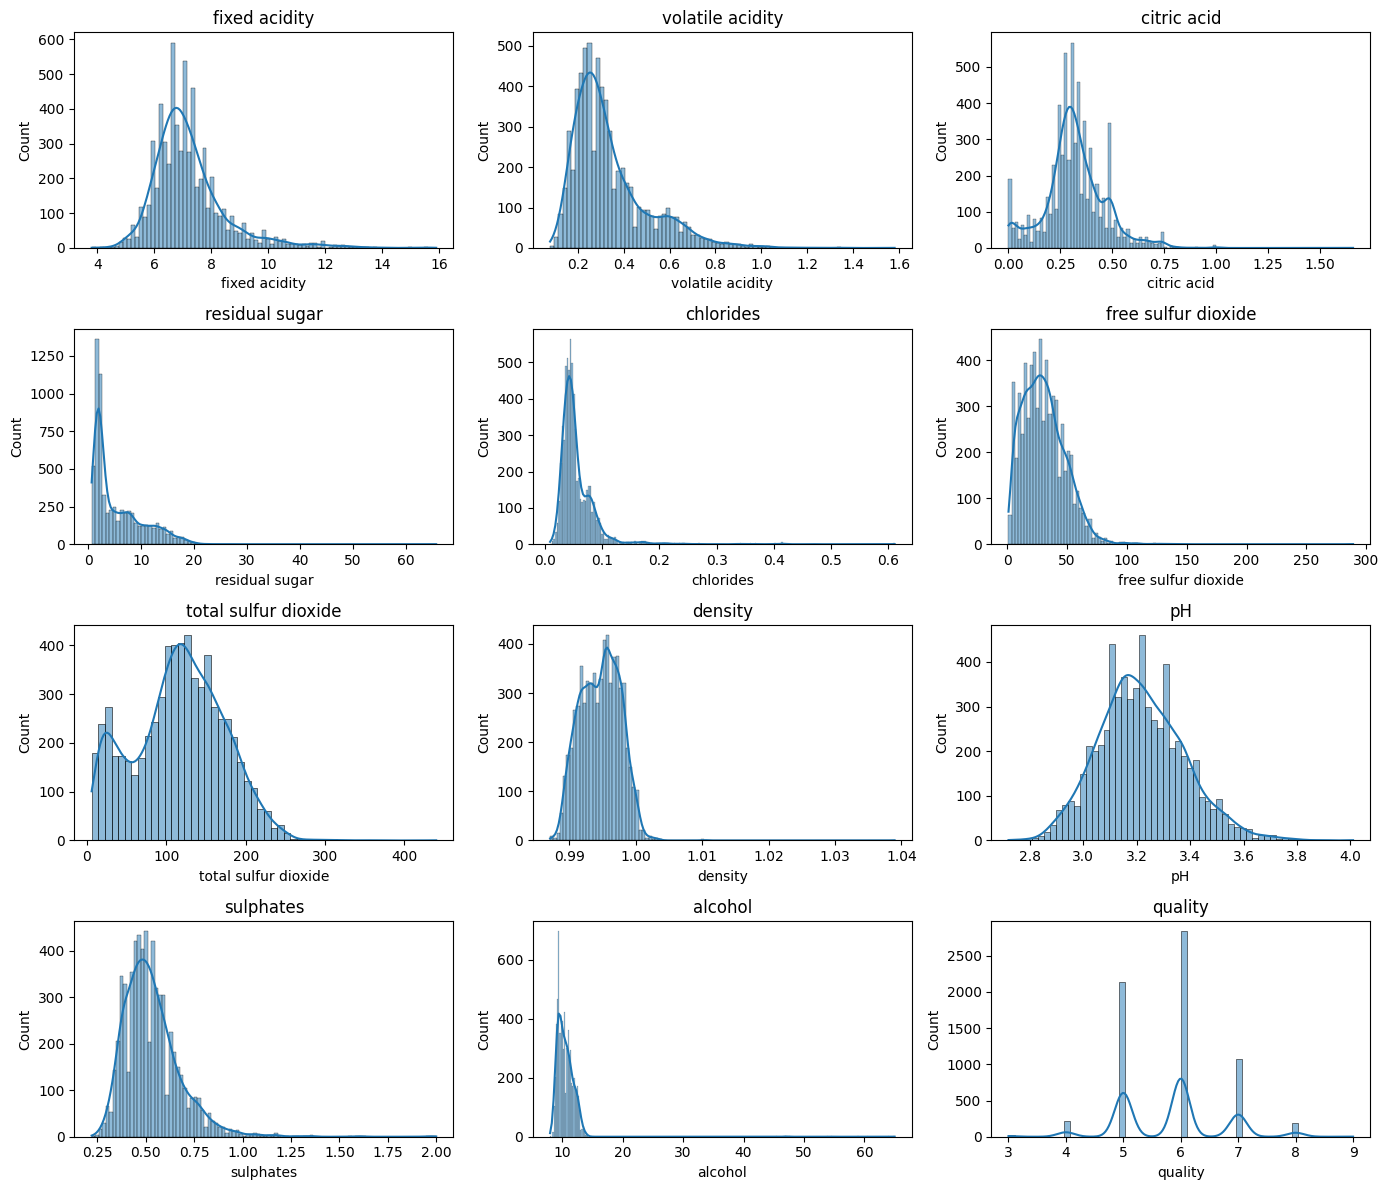

In [7]:
num_cols = df_corrupt.select_dtypes(include='number').columns.tolist()
plt.figure(figsize=(14, 3*len(num_cols)//3))
for i, col in enumerate(num_cols, 1):
    plt.subplot((len(num_cols)+2)//3, 3, i)
    sns.histplot(df_corrupt[col].dropna(), kde=True)
    plt.title(col)
plt.tight_layout()


### Boxplots to visualize outliers

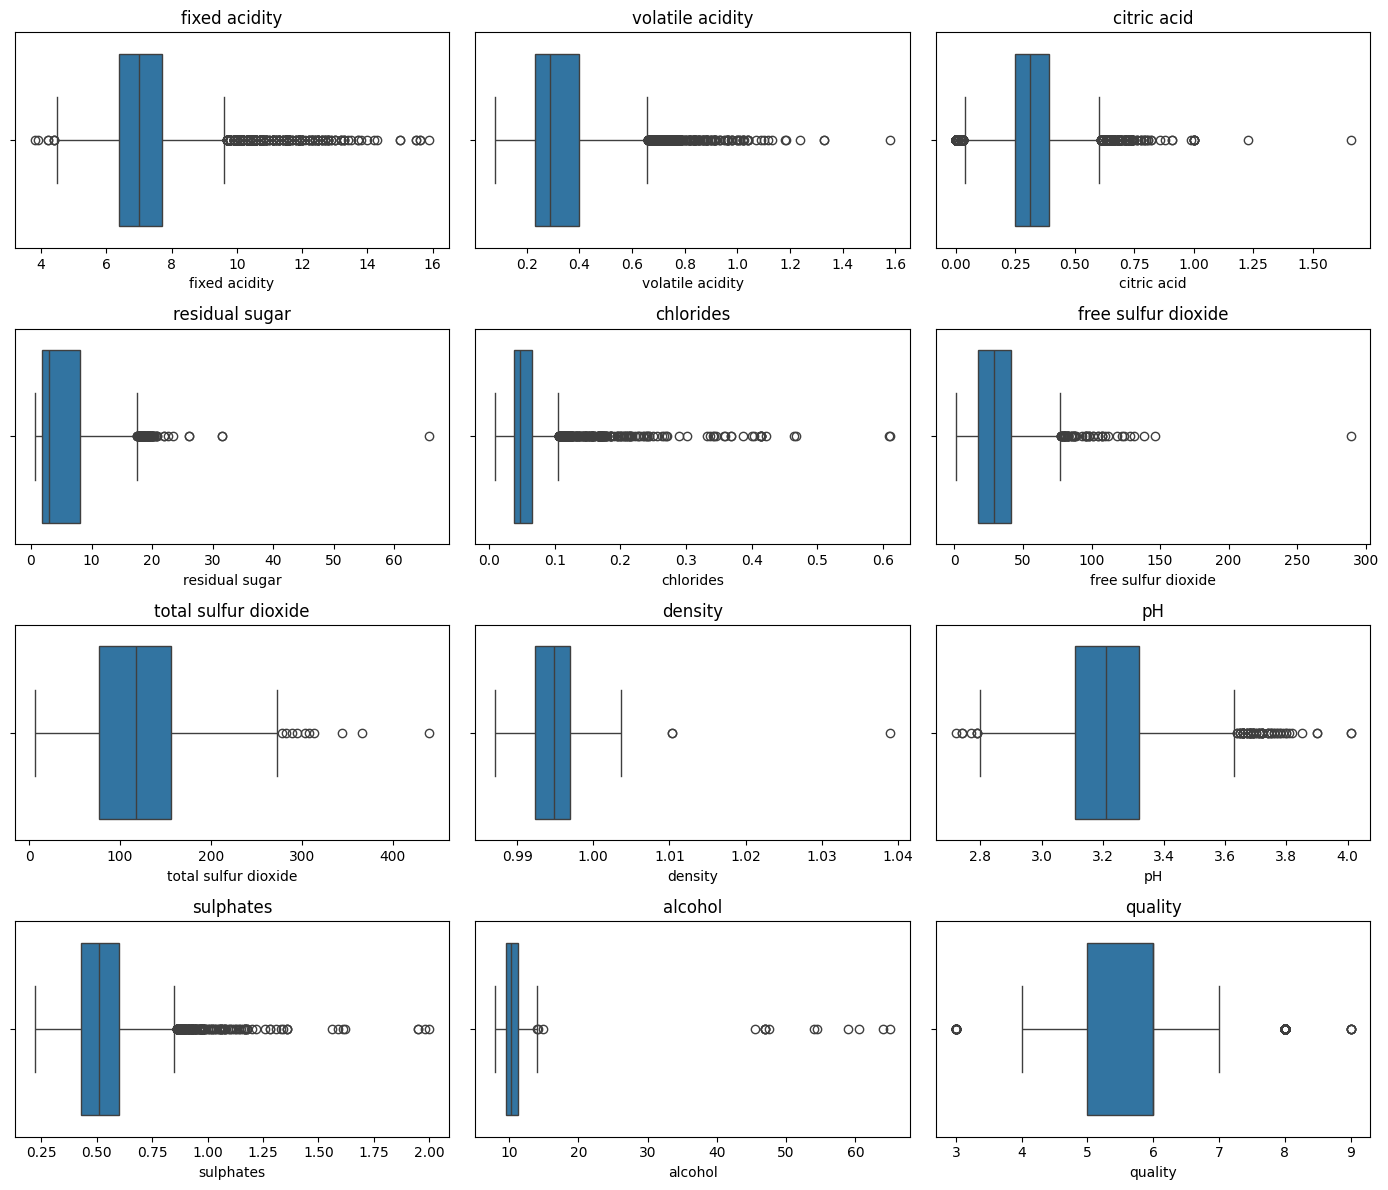

In [8]:
plt.figure(figsize=(14, 3*len(num_cols)//3))
for i, col in enumerate(num_cols, 1):
    plt.subplot((len(num_cols)+2)//3, 3, i)
    sns.boxplot(x=df_corrupt[col])
    plt.title(col)
plt.tight_layout()


### Target distribution: quality

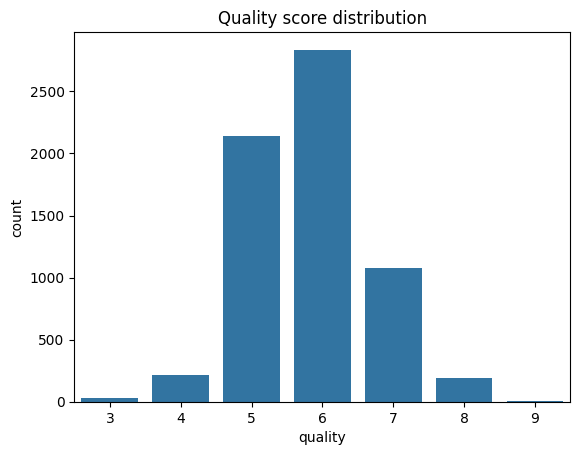

In [9]:
sns.countplot(x='quality', data=df_corrupt, order=sorted(df_corrupt['quality'].unique()))
plt.title('Quality score distribution');


### Compare red vs white

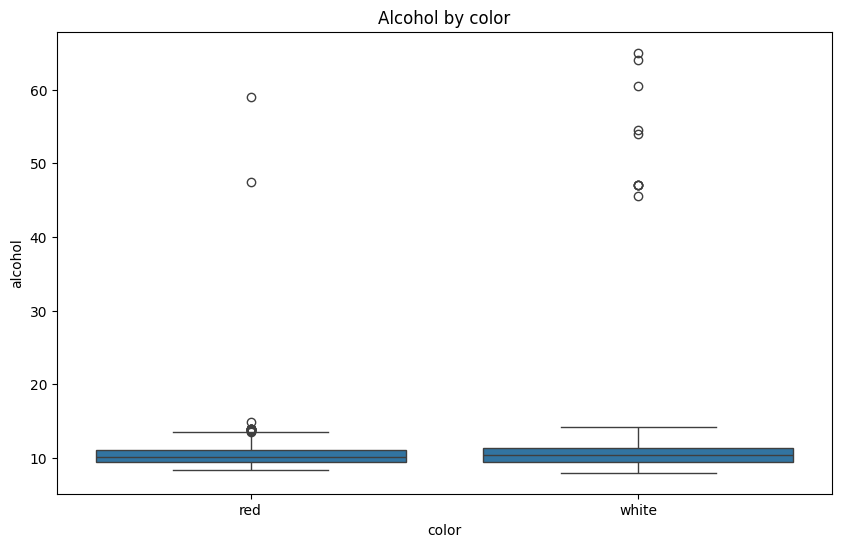

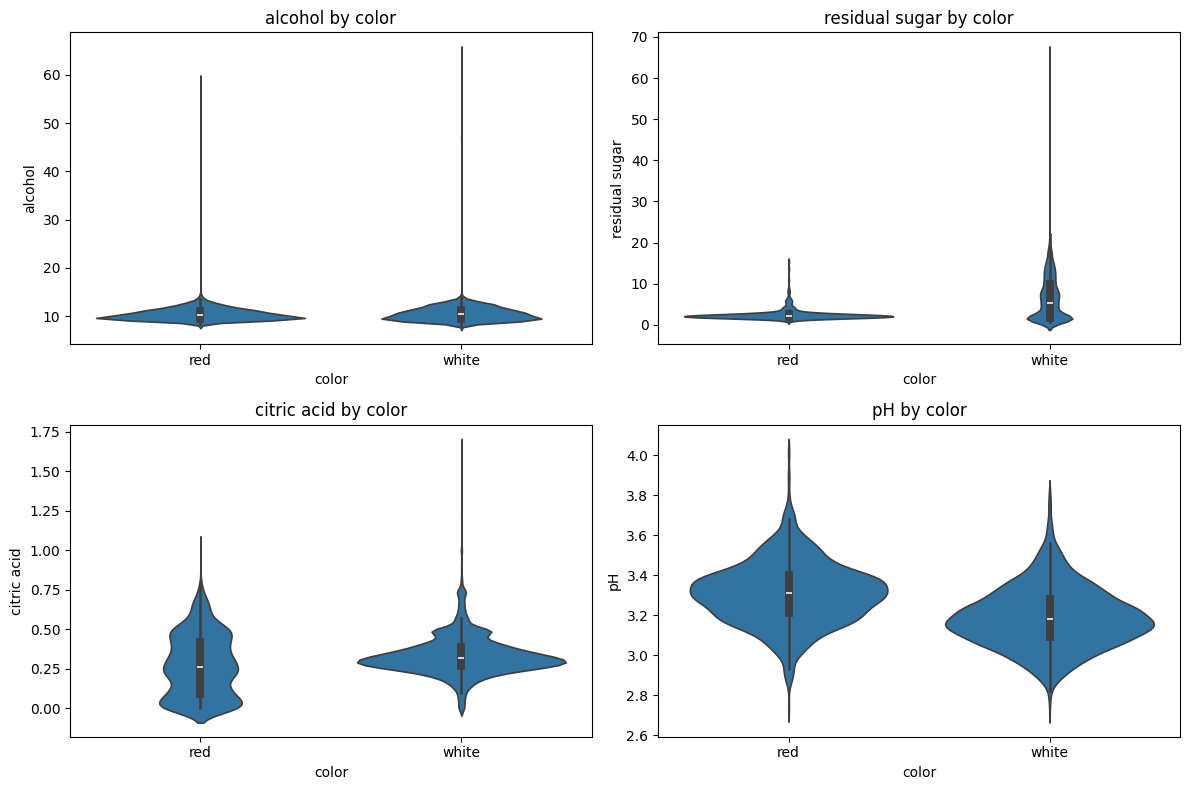

In [12]:
plt.figure(figsize=(10,6))
sns.boxplot(x='color', y='alcohol', data=df_corrupt)
plt.title('Alcohol by color')

# multiple features: use violin grid for a subset
subset = ['alcohol', 'residual sugar', 'citric acid', 'pH']
plt.figure(figsize=(12,8))
for i,col in enumerate(subset,1):
    plt.subplot(2,2,i)
    sns.violinplot(x='color', y=col, data=df_corrupt)
    plt.title(col + ' by color')
plt.tight_layout()

### Correlation matrix & heatmap + interpret

In [15]:
corr = df_corrupt.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag', center=0)
plt.title('Correlation matrix')

corr_with_target = corr['quality'].sort_values(ascending=False)
corr_with_target

ValueError: could not convert string to float: 'red'